#考察・検討課題

* SARIMAモデルの適合度は主要科目についてはそこそこ、あまり動かない科目については微妙。

* 各勘定科目・集計科目を独立に予測しているため、損益構造を反映していない

* 総売上高単体および対売上比でのモデリングをしてみる？

* 損益構造を反映した多変量状態空間モデルを探る？

* 商流から想定される各関係会社間の売上・仕入の関係を記述できるとよい？

* Prophetとか？

* DeepARでディープラーニング？


In [ ]:
!pip install japanize-matplotlib pmdarima pytorch-forecasting fastapi==0.80.0 #torch_xla[tpu]

In [ ]:
import pandas as pd
import numpy as np
import statsmodels as sm
import pmdarima as pmd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# from sklearn import model_selection

import glob
import datetime
from pathlib import Path

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch

#import torch_xla as xla
#import torch_xla.core.xla_model as xm
#import torch_xla.distributed.xla_multiprocessing as xmp

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_folder = ''
folders = glob.glob(root_folder + "/*/BizP+")
df = pd.DataFrame([])'

for files_str in folders:
  files = glob.glob(files_str + '/*')
  for _file_str in files:
    _file = Path(_file_str)
    _df = pd.read_csv(_file)
    _df['会社'] = file.stem[5:8]
    _df['会計年月'] = pd.to_datetime(_file.stem[-6:], format='%Y%m')
    df = pd.concat([df,_df])

root_folder = "/content/drive/Shareddrives/01_組織_TSS_財務経理本部/子会社経理資料/セグメント会計"
folders = glob.glob(root_folder + "/**/BizPL")
df = pd.DataFrame([])

for files_str in folders:
    files = glob.glob(files_str + '/*')
    for _file_str in files:
        _file = Path(_file_str)
        _df = pd.read_csv(_file)
        _df['会社'] = _file.stem[5:8]
        _df['会計年月'] = pd.to_datetime(_file.stem[-6:], format='%Y%m')
        df = pd.concat([df, _df])

NameError: name 'glob' is not defined

In [ ]:
df_data = df.query('科目階層区分 > 0 & 勘定科目コード != 821000 & 勘定科目コード != 824000 & 科目構成要素番号 < 3790 & 会社 != "ATR"').groupby(['会計年月', '会社コード', '会社', '科目構成要素番号', '勘定科目名'])[['期間実績額']].sum()

df_data = df.query('')

df_data = df_data.pivot_table(index=['会計年月'], values=['期間実績額'], columns=['会社コード', '科目構成要素番号', '勘定科目名']).droplevel(0, axis=1).fillna(0)
df_data

会社コード             1001                                                   \
科目構成要素番号          3520          3560       3565         3600       3605   
勘定科目名            商品売上高          受取家賃       受取地代        受取管理料  ロイヤリティー収入   
会計年月                                                                      
2021-07-01  17053225.0  1.593675e+09  2352695.0   87286093.0  4749679.0   
2021-08-01  18402817.0  1.594986e+09  2936526.0   88716270.0  4716462.0   
2021-09-01  17867777.0  1.592122e+09  2273491.0   80197808.0  4280337.0   
2021-10-01  16046131.0  1.604494e+09  2450936.0   84665653.0  4862255.0   
2021-11-01  13383655.0  1.616109e+09  2407231.0   82306694.0  4475343.0   
2021-12-01   2356468.0  1.634119e+09  1780228.0  113618030.0  5768680.0   
2022-01-01   3381360.0  1.636871e+09  2515210.0   97476126.0  6259446.0   
2022-02-01   8925933.0  1.635992e+09  2515210.0   83357119.0  2917278.0   
2022-03-01  16054659.0  1.635870e+09  2363853.0   89241552.0  5300234.0   
2022-04-01   4305258.0  1.708747e+09  2551078.0   99237919.0  4921873.0   
2022-05-01   2121576.0  1.710124e+09  2494293.0  102247301.0  5227595.0   
2022-06-01  22670919.0  1.731418e+09  2494293.0   93643322.0  5010203.0   
2022-07-01  22746446.0  1.682469e+09  2270077.0   92168478.0  6243220.0   
2022-08-01  17736133.0  1.686502e+09  2270077.0   96390586.0  5754767.0   
2022-09-01  16728254.0  1.700509e+09  2270077.0   90039578.0  4926331.0   
2022-10-01  14850606.0  1.717688e+09  2270077.0   97114081.0  4763011.0   
2022-11-01  14976780.0  1.717830e+09  2341160.0   93138942.0  5067875.0   
2022-12-01  12320149.0  1.676570e+09  2353756.0  118090492.0  6432907.0   
2023-01-01  20599130.0  1.676772e+09  2367396.0  107570568.0  4827504.0   
2023-02-01  19751487.0  1.685918e+09  2388406.0   93866509.0  4203449.0   
2023-03-01  15234923.0  1.690528e+09  2484211.0   99291359.0  5441484.0   
2023-04-01   4305258.0  1.708747e+09  2551078.0   99237919.0  4921873.0   
2023-05-01   2121576.0  1.710124e+09  2494293.0  102247301.0  5227595.0   
2023-06-01  22670919.0  1.731418e+09  2494293.0   93643322.0  5010203.0   
2023-07-01  18225337.0  1.800055e+09  2494293.0  102334638.0  6108113.0   
2023-08-01  17143953.0  1.801774e+09  2445293.0  102897939.0  6120940.0   
2023-09-01  15923823.0  1.800125e+09  2517193.0   91129982.0  5208674.0   
2023-10-01  16922662.0  1.804486e+09  2617074.0   98701316.0  5035969.0   
2023-11-01  16084781.0  1.809185e+09  2557074.0   87510585.0  5094379.0   
2023-12-01  17596011.0  1.830392e+09  2620198.0  126158731.0  6605665.0   
2024-01-01  19087395.0  1.829061e+09  2694808.0  103433996.0  5094366.0   
2024-02-01  12702756.0  1.839567e+09  2649266.0   78152511.0  4737937.0   
2024-03-01  13039860.0  1.856902e+09  2621345.0   89295379.0  5585224.0   
2024-04-01  14886282.0  1.865639e+09  2625667.0   81189876.0  5066658.0   

会社コード                                                                     ...  \
科目構成要素番号            3610      3620          3670         3675       3685  ...   
勘定科目名         コンサルティング収入 関係会社受取配当金          運送収入      その他の売上高 売上-レジ・サービス  ...   
会計年月                                                                      ...   
2021-07-01  1.100051e+09       0.0  1.254382e+09   42164408.0        0.0  ...   
2021-08-01  1.114395e+09       0.0  1.203535e+09   46915760.0        0.0  ...   
2021-09-01  9.945014e+08       0.0  1.167009e+09   43803353.0        0.0  ...   
2021-10-01  1.078835e+09       0.0  1.280851e+09   66688717.0        0.0  ...   
2021-11-01  1.026728e+09       0.0  1.233252e+09   48717243.0        0.0  ...   
2021-12-01  1.212538e+09       0.0  1.390812e+09   48559571.0        0.0  ...   
2022-01-01  1.031659e+09       0.0  1.088300e+09   63660018.0     1000.0  ...   
2022-02-01  9.460828e+08       0.0  1.073922e+09   43017715.0     2182.0  ...   
2022-03-01  1.086802e+09       0.0  1.336395e+09   47474033.0     4230.0  ...   
2022-04-01  8.256445e+08       0.0  1.328799e+09   62829417.0    78159.0  ...   
2022-05-01  8.5

## Auto_ARIMAを用いて、AICが最も小さい値を示したモデルを選定する。加えて、各勘定科目に対してモデル探索する。
モデルを辞書型で格納することにより、後々にも確認することができる。

In [ ]:
models = {}

for __df in df_data.columns:
    _model = pmd.auto_arima(df_data[[__df]], start_p=0, start_q=0, max_p=5, max_q=5, max_d=2, start_P=0, start_Q=0, max_P=5, max_Q=5, max_D=1, m=12, trace=True)
    models[__df] = _model



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1161.384, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1157.798, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1151.416, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1224.535, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1155.044, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1153.246, Time=0.43 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1153.189, Time=0.44 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1154.679, Time=0.19 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1155.109, Time=0.63 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1158.559, Time=0.22 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1153.424, Time=0.44 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=1152.969, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1154.856, Time=0.21 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=1154.846, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1590.010, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1594.985, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1599.059, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1602.586, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1591.975, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1591.880, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1593.449, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1587.549, Time=0.04 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1589.509, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1589.402, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1591.117, Time=0.04 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1591.948, Time=0.04 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=943.577, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=945.577, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=942.748, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=944.706, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=946.627, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 0.670 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=869.110, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=873.000, Time=0.97 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=871.662, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=916.904, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=871.036, Time=0.14 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=871.006, Time=0.09 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=872.877, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=873.206, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[

In [ ]:
models

{(1001,
  3520,
  '商品売上高'): ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
       suppress_warnings=True),
 (1001,
  3560,
  '受取家賃'): ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
       suppress_warnings=True),
 (1001,
  3565,
  '受取地代'): ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
       suppress_warnings=True),
 (1001,
  3600,
  '受取管理料'): ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
       suppress_warnings=True, with_intercept=False),
 (1001,
  3605,
  'ロイヤリティー収入'): ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 1, 12),
       suppress_warnings=True),
 (1001,
  3610,
  'コンサルティング収入'): ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
       suppress_warnings=True, with_intercept=False),
 (1001,
  3620,
  '関係会社受取配当金'): ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 (1001,
  3670,
  '運送収入'): ARIMA(order=(0, 

In [ ]:
results = {}
for __df in df_data.columns:
    _result = models[__df]
    results[__df] = _result.predict(n_periods=12)

results = []

for _df in df_data.columns:
  _result = models[_df]
  results[_df] = _result.predict(n_periods=12)

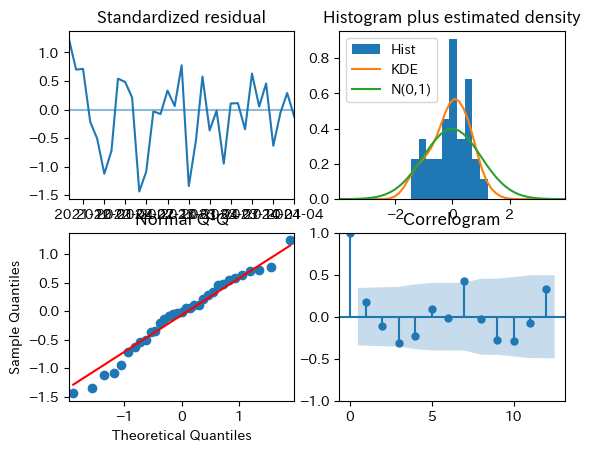

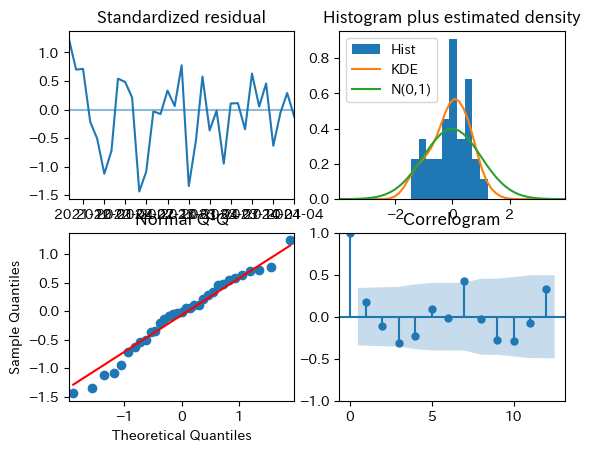

In [ ]:
models[(1001, 3700, '＜総売上高＞')].plot_diagnostics(lags=12)

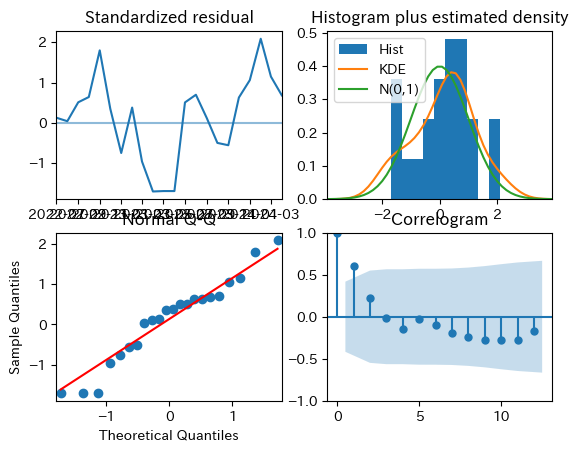

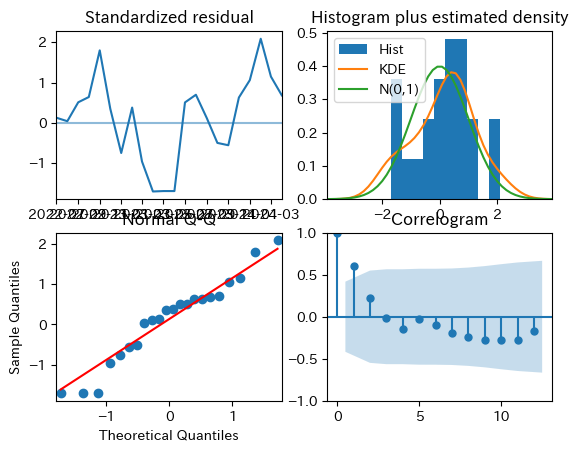

In [ ]:
models[(1001, 3781, '＜売上総利益＞')].plot_diagnostics(lags=12)

In [ ]:
df_pred = pd.concat([df_data, pd.DataFrame(results)])
df_pred

1001                                            \
                    3520          3560          3565          3600   
                   商品売上高          受取家賃          受取地代         受取管理料   
2021-07-01  1.705322e+07  1.593675e+09  2.352695e+06  8.728609e+07   
2021-08-01  1.840282e+07  1.594986e+09  2.936526e+06  8.871627e+07   
2021-09-01  1.786778e+07  1.592122e+09  2.273491e+06  8.019781e+07   
2021-10-01  1.604613e+07  1.604494e+09  2.450936e+06  8.466565e+07   
2021-11-01  1.338366e+07  1.616109e+09  2.407231e+06  8.230669e+07   
2021-12-01  2.356468e+06  1.634119e+09  1.780228e+06  1.136180e+08   
2022-01-01  3.381360e+06  1.636871e+09  2.515210e+06  9.747613e+07   
2022-02-01  8.925933e+06  1.635992e+09  2.515210e+06  8.335712e+07   
2022-03-01  1.605466e+07  1.635870e+09  2.363853e+06  8.924155e+07   
2022-04-01  4.305258e+06  1.708747e+09  2.551078e+06  9.923792e+07   
2022-05-01  2.121576e+06  1.710124e+09  2.494293e+06  1.022473e+08   
2022-06-01  2.267092e+07  1.731418e+09  2.494293e+06  9.364332e+07   
2022-07-01  2.274645e+07  1.682469e+09  2.270077e+06  9.216848e+07   
2022-08-01  1.773613e+07  1.686502e+09  2.270077e+06  9.639059e+07   
2022-09-01  1.672825e+07  1.700509e+09  2.270077e+06  9.003958e+07   
2022-10-01  1.485061e+07  1.717688e+09  2.270077e+06  9.711408e+07   
2022-11-01  1.497678e+07  1.717830e+09  2.341160e+06  9.313894e+07   
2022-12-01  1.232015e+07  1.676570e+09  2.353756e+06  1.180905e+08   
2023-01-01  2.059913e+07  1.676772e+09  2.367396e+06  1.075706e+08   
2023-02-01  1.975149e+07  1.685918e+09  2.388406e+06  9.386651e+07   
2023-03-01  1.523492e+07  1.690528e+09  2.484211e+06  9.929136e+07   
2023-04-01  4.305258e+06  1.708747e+09  2.551078e+06  9.923792e+07   
2023-05-01  2.121576e+06  1.710124e+09  2.494293e+06  1.022473e+08   
2023-06-01  2.267092e+07  1.731418e+09  2.494293e+06  9.364332e+07   
2023-07-01  1.822534e+07  1.800055e+09  2.494293e+06  1.023346e+08   
2023-08-01  1.714395e+07  1.801774e+09  2.445293e+06  1.028979e+08   
2023-09-01  1.592382e+07  1.800125e+09  2.517193e+06  9.112998e+07   
2023-10-01  1.692266e+07  1.804486e+09  2.617074e+06  9.870132e+07   
2023-11-01  1.608478e+07  1.809185e+09  2.557074e+06  8.751058e+07   
2023-12-01  1.759601e+07  1.830392e+09  2.620198e+06  1.261587e+08   
2024-01-01  1.908740e+07  1.829061e+09  2.694808e+06  1.034340e+08   
2024-02-01  1.270276e+07  1.839567e+09  2.649266e+06  7.815251e+07   
2024-03-01  1.303986e+07  1.856902e+09  2.621345e+06  8.929538e+07   
2024-04-01  1.488628e+07  1.865639e+09  2.625667e+06  8.118988e+07   
2024-05-01  1.214916e+07  1.873884e+09  2.456828e+06  8.471291e+07   
2024-06-01  1.601335e+07  1.882169e+09  2.456828e+06  7.464038e+07   
2024-07-01  1.397557e+07  1.886225e+09  2.456828e+06  6.811518e+07   
2024-08-01  1.471946e+07  1.894555e+09  2.456828e+06  6.917896e+07   
2024-09-01  1.430731e+07  1.903369e+09  2.456828e+06  5.781640e+07   
2024-10-01  1.505881e+07  1.912091e+09  2.456828e+06  6.582940e+07   
2024-11-01  1.437976e+07  1.920174e+09  2.456828e+06  5.441004e+07   
2024-12-01  1.472317e+07  1.926160e+09  2.456828e+06  9.188304e+07   
2025-01-01  1.364569e+07  1.934455e+09  2.456828e+06  7.019775e+07   
2025-02-01  1.123267e+07  1.942668e+09  2.456828e+06  4.506286e+07   
2025-03-01  1.307959e+07  1.950477e+09  2.456828e+06  5.608987e+07   
2025-04-01  1.541662e+07  1.959085e+09  2.456828e+06  4.632173e+07   

                                                                             \
                    3605          3610      3620          3670         3675   
               ロイヤリティー収入    コンサルティング収入 関係会社受取配当金          運送収入      その他の売上高   
2021-07-01  4.749679e+06  1.100051e+09       0.0  1.254382e+09   42164408.0   
2021-08-01  4.716462e+06  1.114395e+09       0.0  1.203535e+09   46915760.0   
2021-09-01  4.280337e+06  9.945014e+08       0.0  1.167009e+09   43803353.0   
2021-10-01  4.862255e+06  1.078835e+09       0.0  1.280851e+09   66688717.0   
2021-11-01  4.475343e+06  1.026728e+

In [ ]:
df_pred.to_csv(root_folder + '/df_pred.csv')

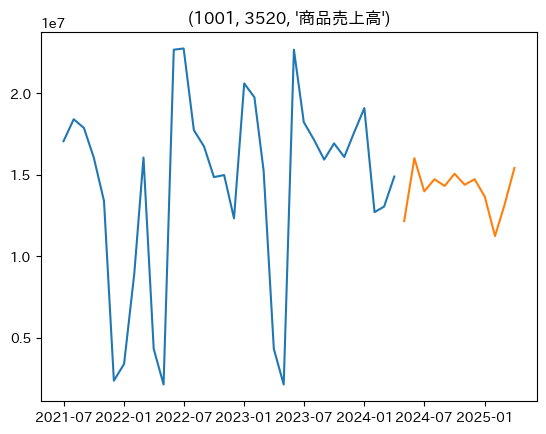

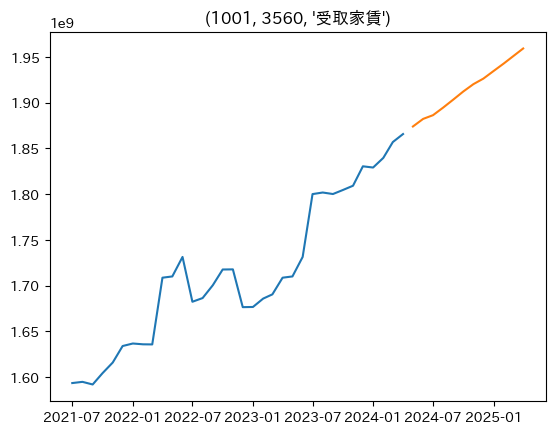

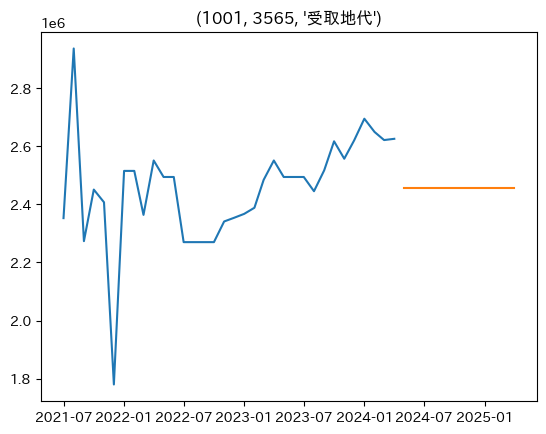

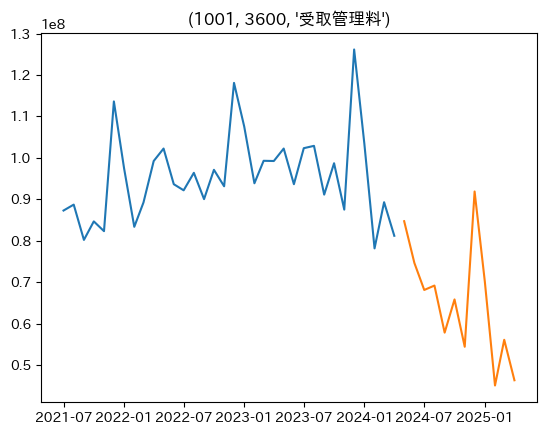

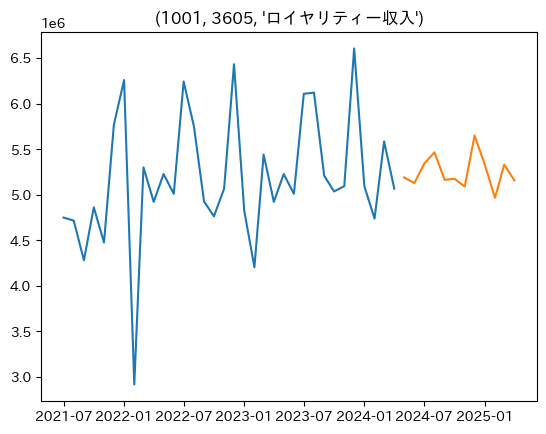

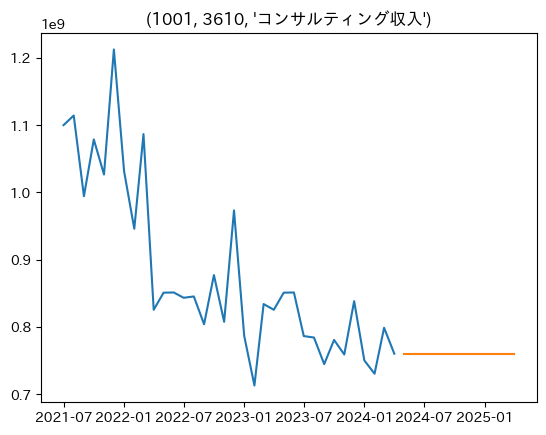

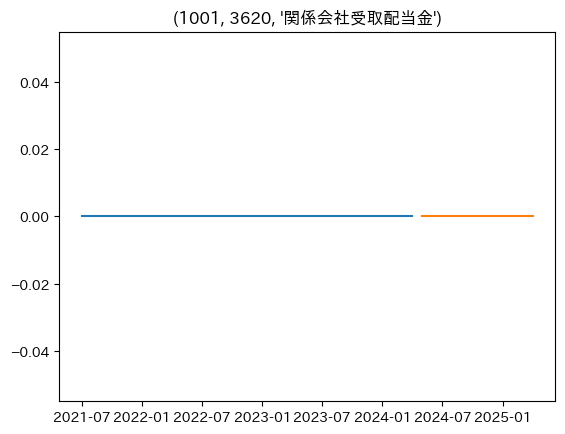

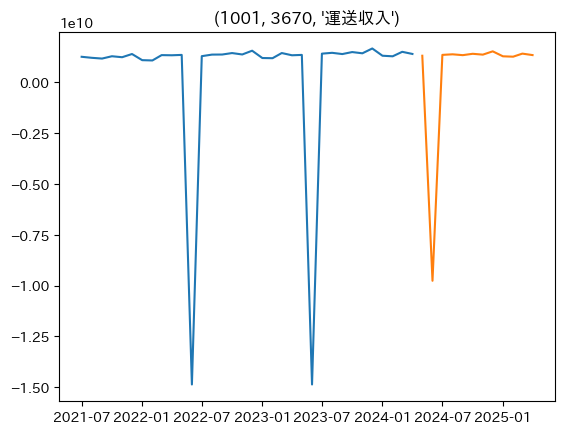

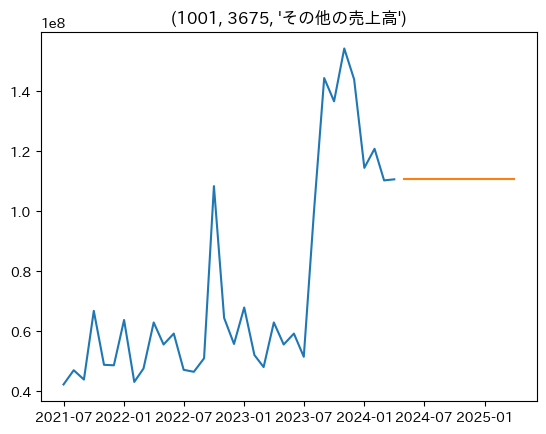

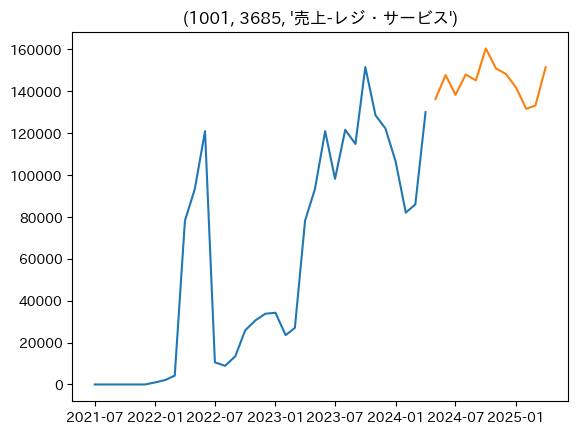

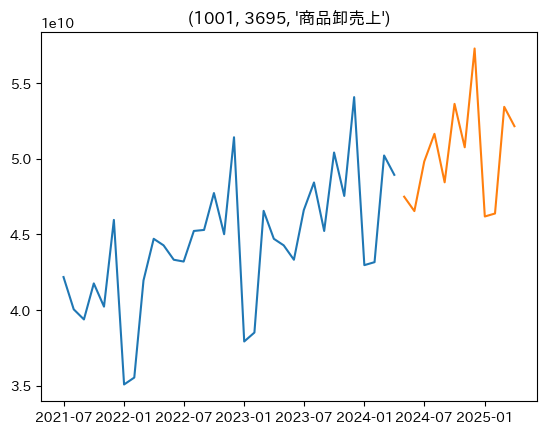

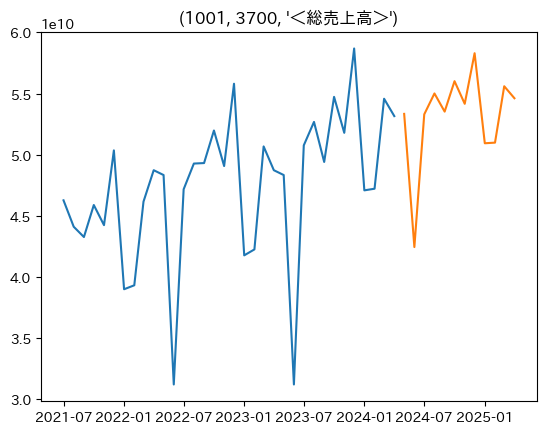

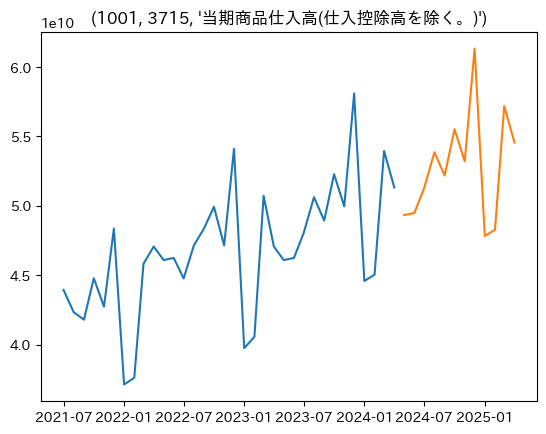

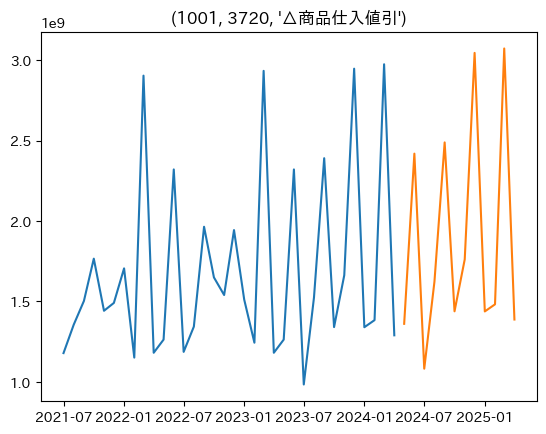

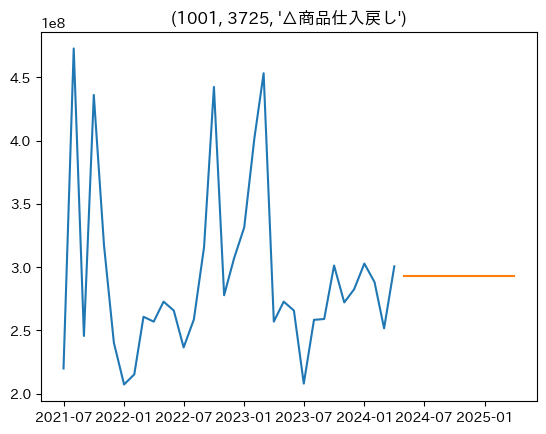

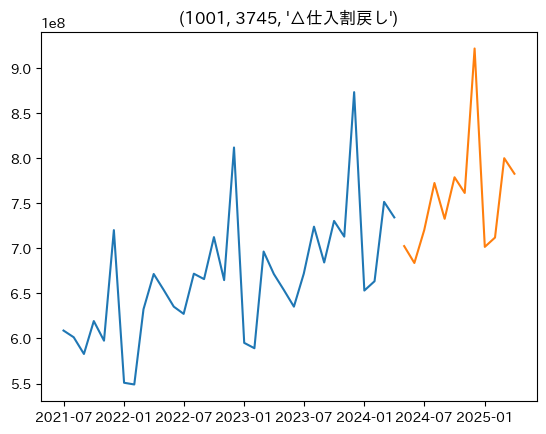

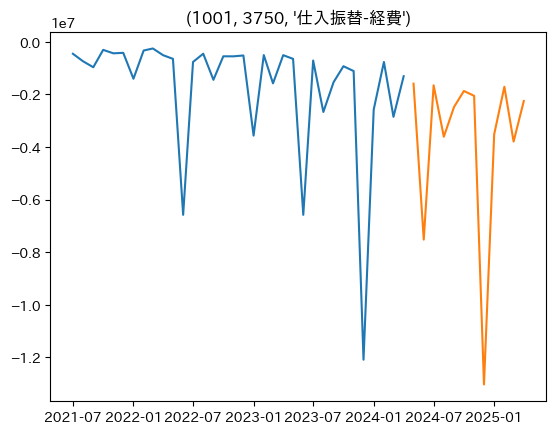

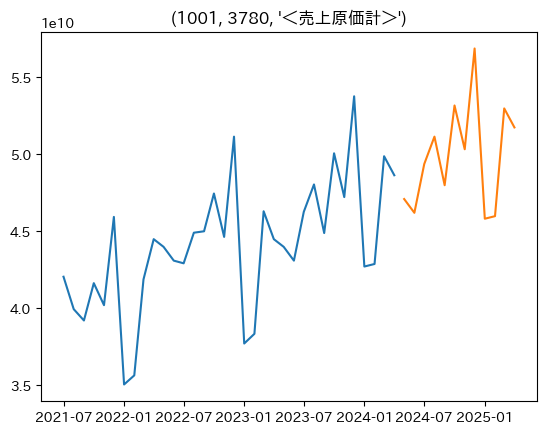

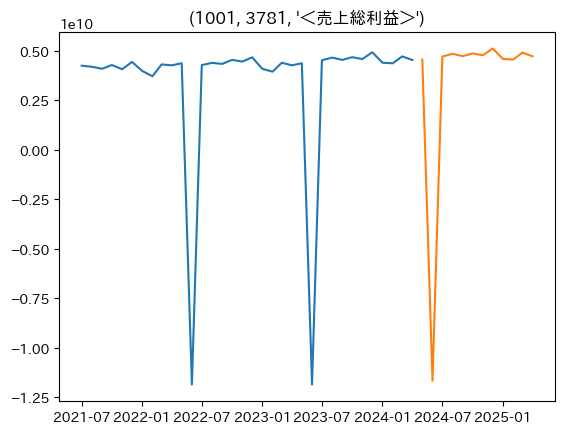

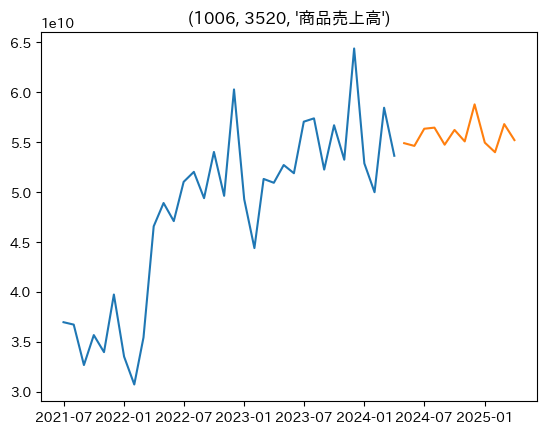

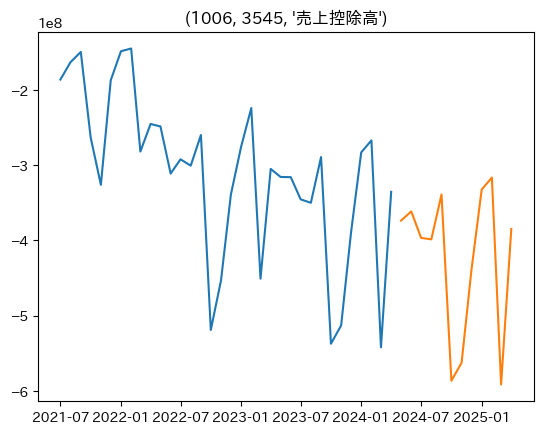

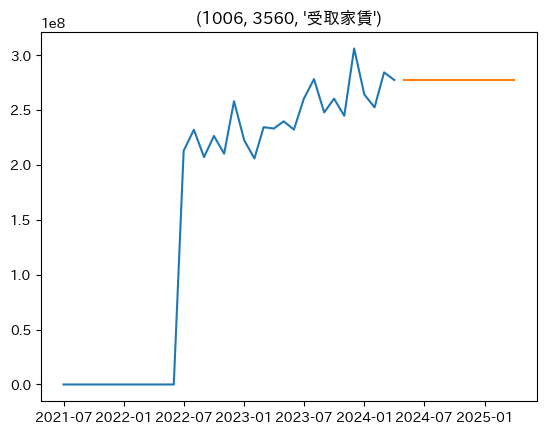

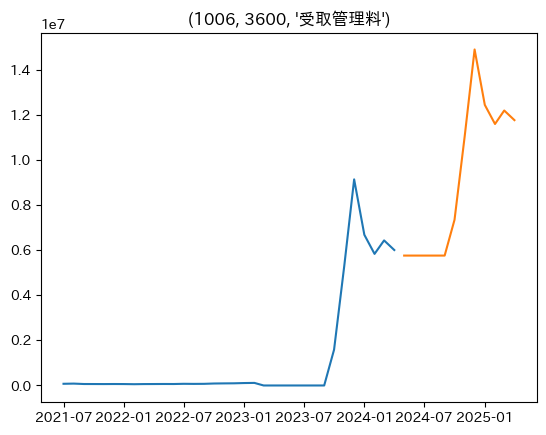

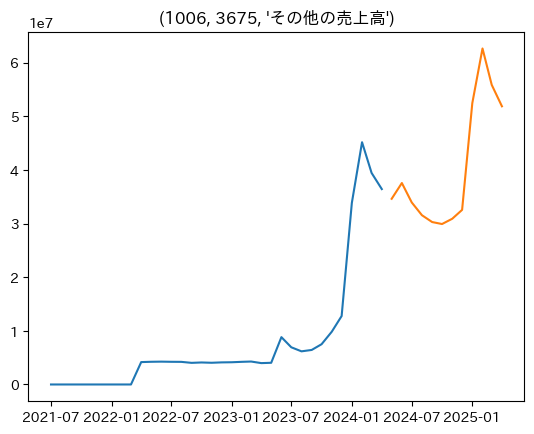

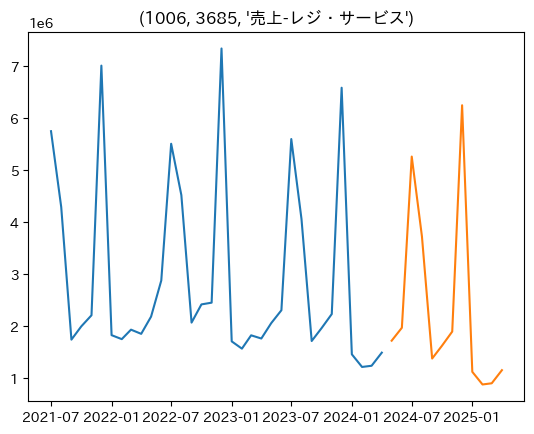

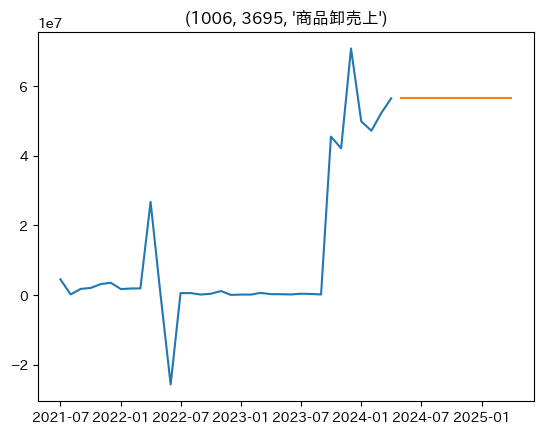

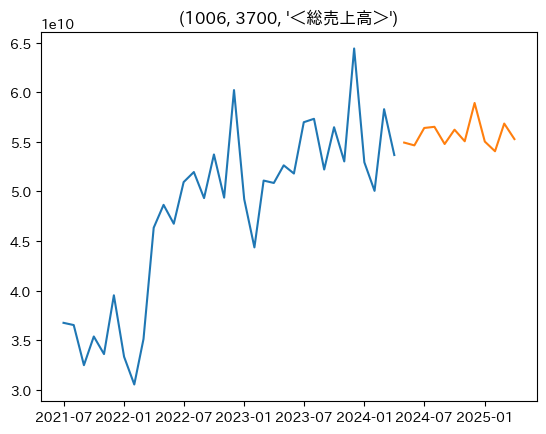

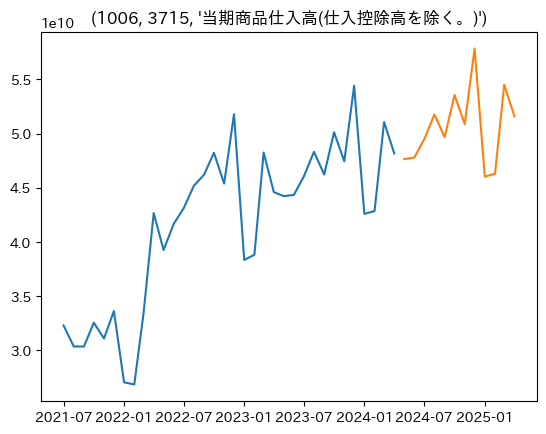

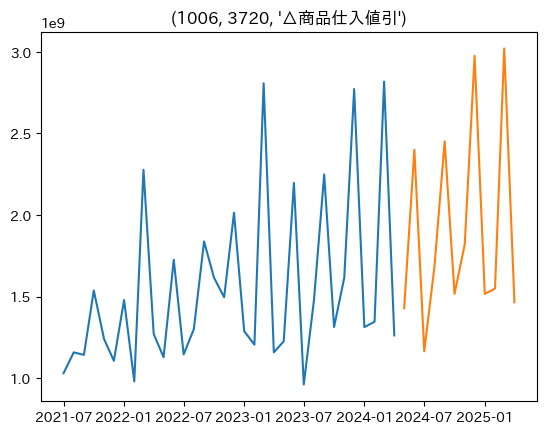

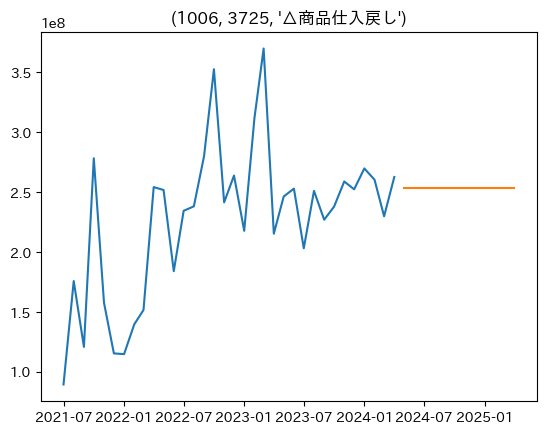

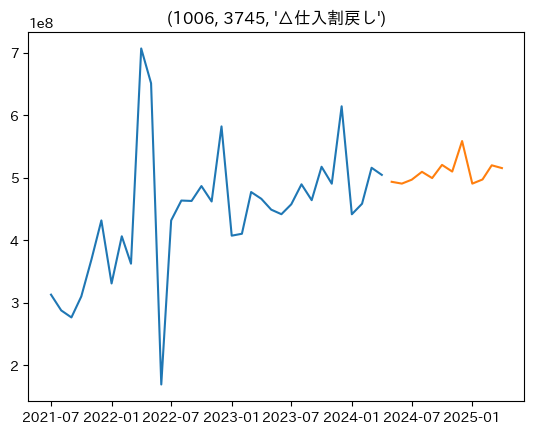

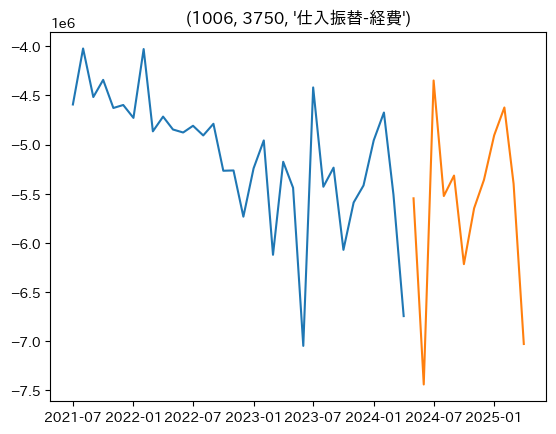

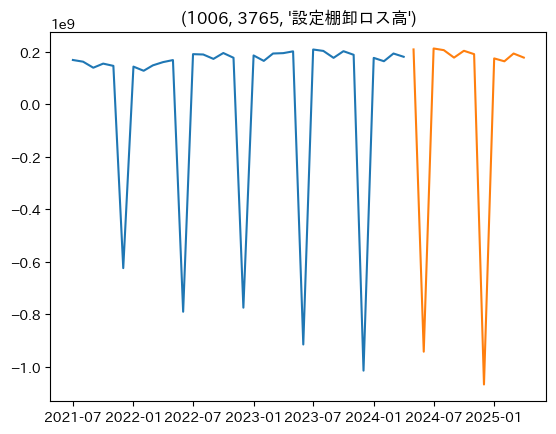

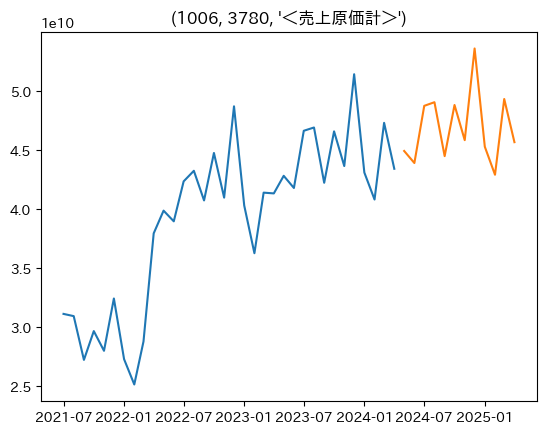

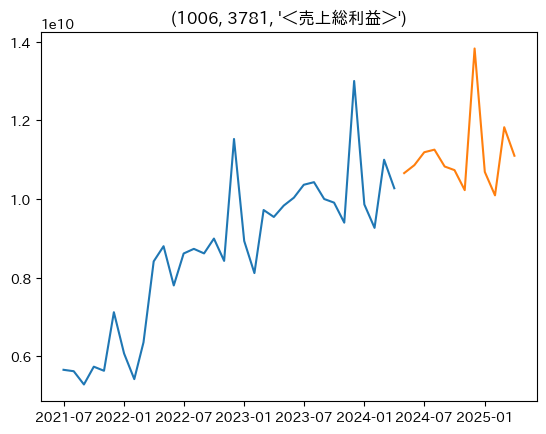

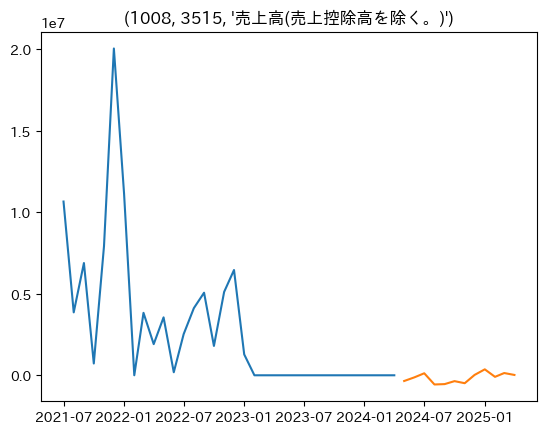

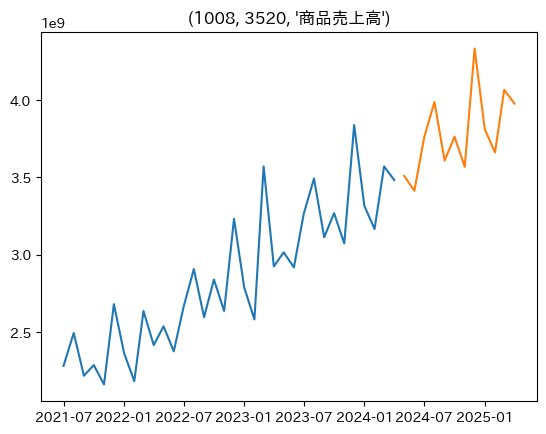

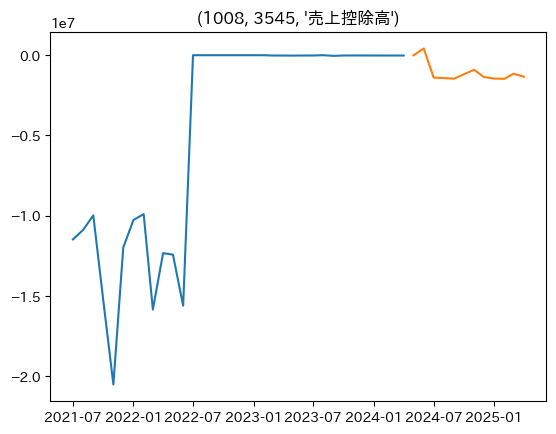

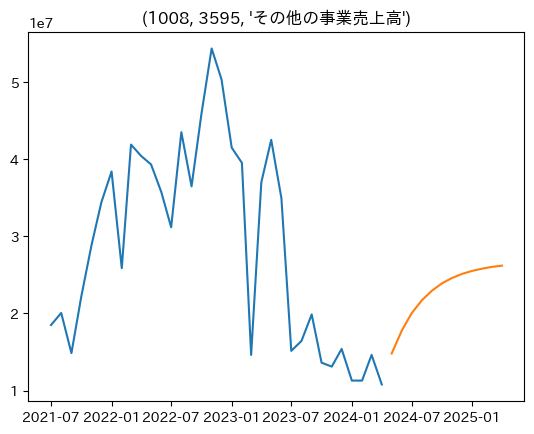

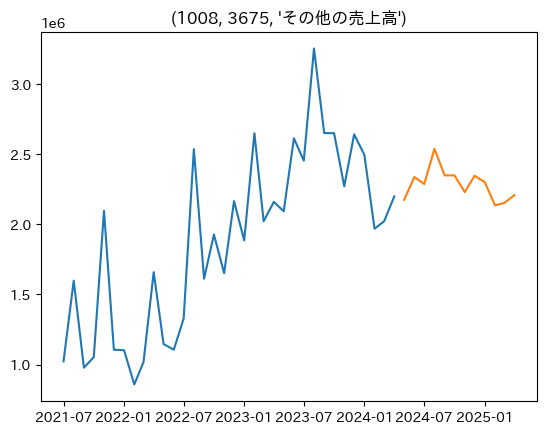

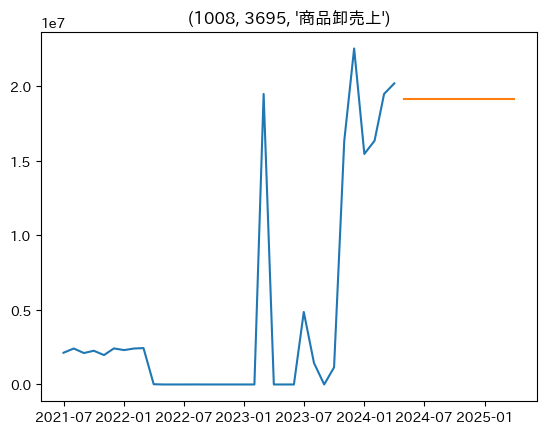

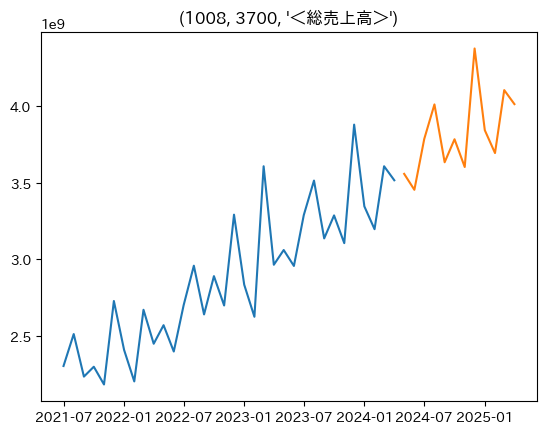

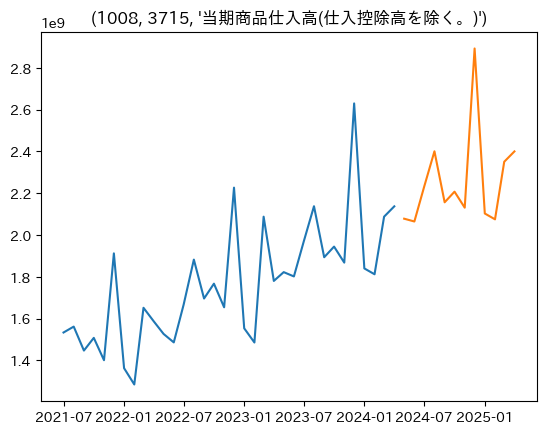

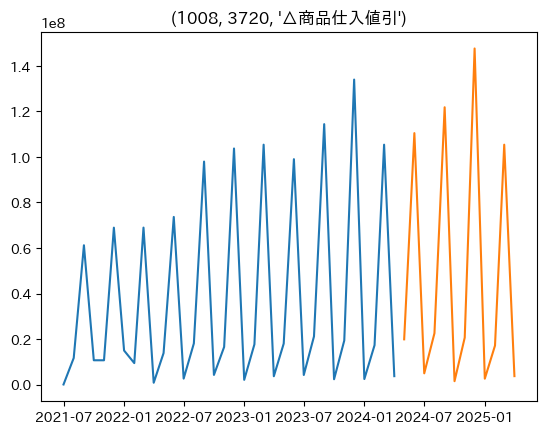

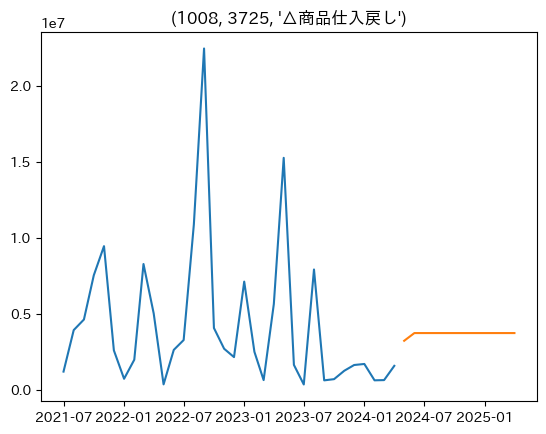

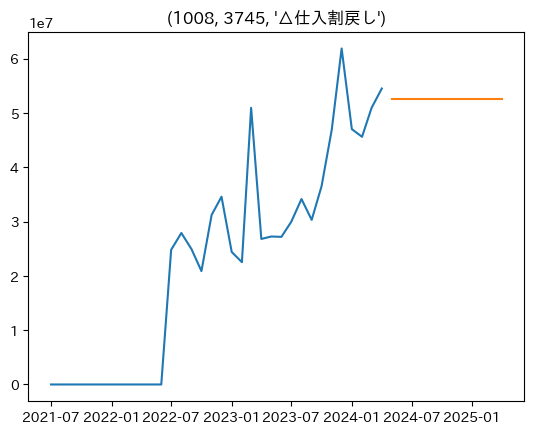

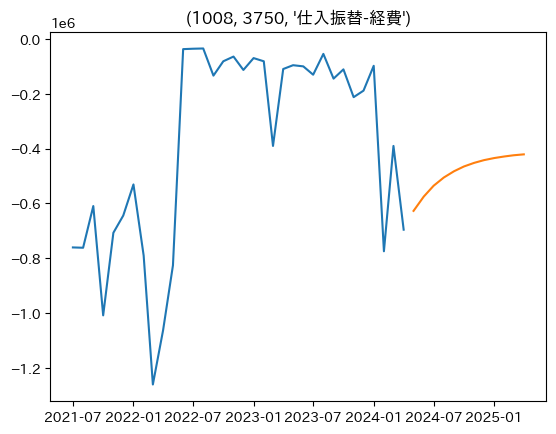

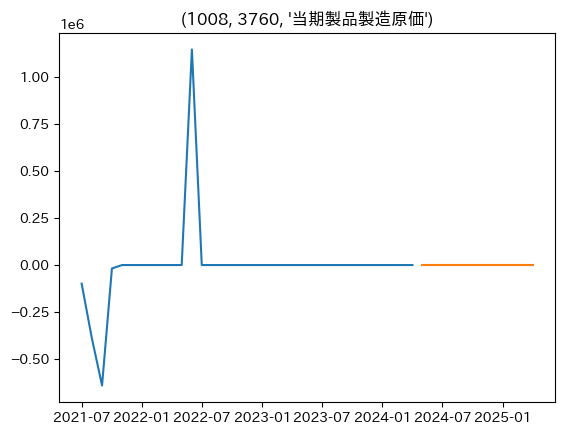

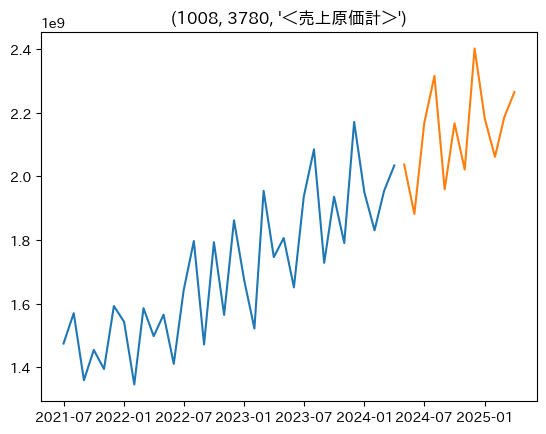

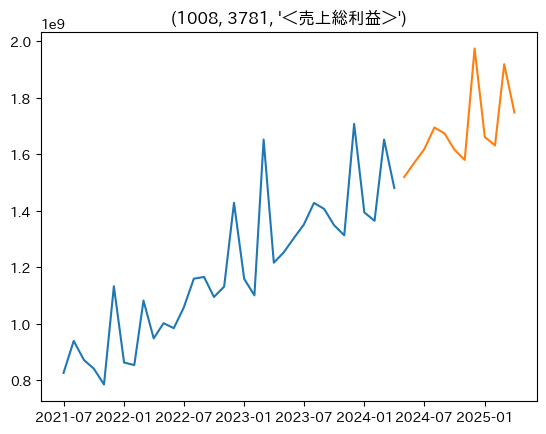

In [ ]:
for __df in df_data.columns:
    plt.title(__df)
    plt.plot(df_data[__df])
    plt.plot(pd.DataFrame(results[__df]))


    plt.show()

# DeepAR（RNN)

In [ ]:
df_data.index = df_data.index.to_period(freq='M')

In [ ]:
df_data_melted = df_data.reset_index().reset_index().melt(id_vars=['index', '会計年月'], value_name='金額')
df_data_melted

,index,会計年月,会社コード,科目構成要素番号,勘定科目名,金額
0,0,2021-07,1001,3520,商品売上高,1.705322e+07
1,1,2021-08,1001,3520,商品売上高,1.840282e+07
2,2,2021-09,1001,3520,商品売上高,1.786778e+07
3,3,2021-10,1001,3520,商品売上高,1.604613e+07
4,4,2021-11,1001,3520,商品売上高,1.338366e+07
...,...,...,...,...,...,...
1695,29,2023-12,1008,3781,＜売上総利益＞,1.707752e+09
1696,30,2024-01,1008,3781,＜売上総利益＞,1.394458e+09
1697,31,2024-02,1008,3781,＜売上総利益＞,1.364684e+09
1698,32,2024-03,1008,3781,＜売上総利益＞,1.652198e+09


In [ ]:
max_encoder_length = 34
max_prediction_length = 6

training_cutoff = df_data_melted["index"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

dataset = TimeSeriesDataSet(
    df_data_melted,
    time_idx='index',
    group_ids=['会社コード', '科目構成要素番号', '勘定科目名'],
    target='金額',
    min_encoder_length=12,
    max_encoder_length=max_encoder_length,
    min_prediction_length=6,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["金額"],
    categorical_encoders={"会社コード": NaNLabelEncoder().fit(df_data_melted.会社コード), "科目構成要素番号": NaNLabelEncoder().fit(df_data_melted.科目構成要素番号), "勘定科目名": NaNLabelEncoder().fit(df_data_melted.勘定科目名)},
    static_categoricals=['会社コード', '科目構成要素番号', '勘定科目名'],
)

validation = TimeSeriesDataSet.from_dataset(dataset, df_data_melted, min_prediction_idx=training_cutoff + 1)
batch_size = 2

train_dataloader = dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized")

In [ ]:
train_dataloader.dataset

TimeSeriesDataSet[length=1650](
	time_idx='index',
	target='金額',
	group_ids=['会社コード', '科目構成要素番号', '勘定科目名'],
	weight=None,
	max_encoder_length=34,
	min_encoder_length=12,
	min_prediction_idx=0,
	min_prediction_length=6,
	max_prediction_length=6,
	static_categoricals=['会社コード', '科目構成要素番号', '勘定科目名'],
	static_reals=['encoder_length'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['金額'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=True,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'会社コード': NaNLabelEncoder(add_nan=False, warn=True), '科目構成要素番号': NaNLabelEncoder(add_nan=False, warn=True), '勘定科目名': NaNLabelEncoder(add_nan=False, warn=True), '__group_id__会社コード': NaNLabelEncoder(a

In [ ]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
baseline_predictions.output
#SMAPE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU av

tensor([[1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07],
        [1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07],
        [1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07, 1.6923e+07],
        ...,
        [1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09],
        [1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09],
        [1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09, 1.3492e+09]])

In [ ]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    dataset,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpoi

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 3.548133892335755e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 3.548133892335755e-05
INFO: Restoring states from the checkpoint path at /content/.lr_find_18498c1a-420e-426b-b9d6-80c157f2daab.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_18498c1a-420e-426b-b9d6-80c157f2daab.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_18498c1a-420e-426b-b9d6-80c157f2daab.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_18498c1a-420e-426b-b9d6-80c157f2daab.ckpt


suggested learning rate: 3.548133892335755e-05


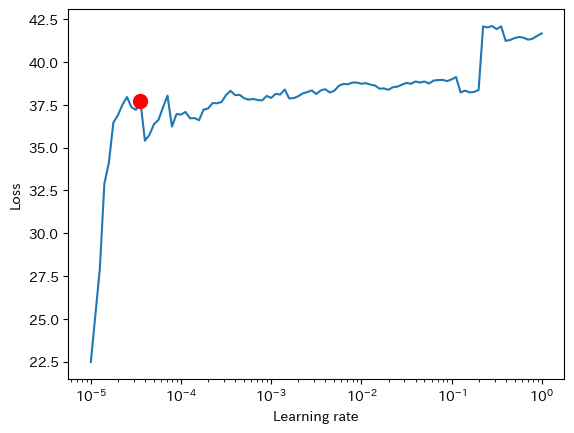

In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    dataset,
    learning_rate=3.548133892335755e-05,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

for i in range(3):
    if i > 0:
        trainer.save_checkpoint('/content/drive/Shareddrives/01_組織_TSS_財務経理本部/子会社経理資料/セグメント会計/checkpoints')
        dl_model = DeepAR.load_from_checkpoint('/content/drive/Shareddrives/01_組織_TSS_財務経理本部/子会社経理資料/セグメント会計/checkpoints')
        net = dl_model
        net.max_epochs = net.max_epochs + 10
    else:
        pass
    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 441   
3 | rnn                    | LSTM                               | 14.0 K
4 | distribution_projector | Linear                        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /content/lightning_logs/version_12/checkpoints exists and is not empty.
INFO: 
  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 441   
3 | rnn                    | LSTM                               | 14.0 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: 
  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 441   
3 | rnn                    | LSTM                               | 14.0 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
15.5 K    Trainable params
0         Non-trainable params
15.5 K    Total params
0.062     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name                   | Type                               | Params
-

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
#MAE()(predictions.output, predictions.y)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


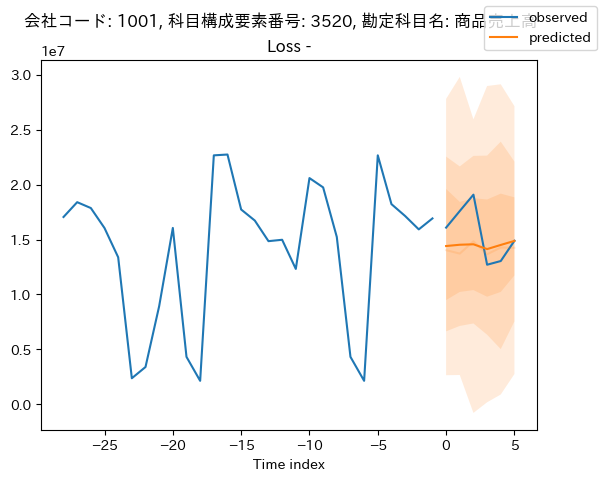

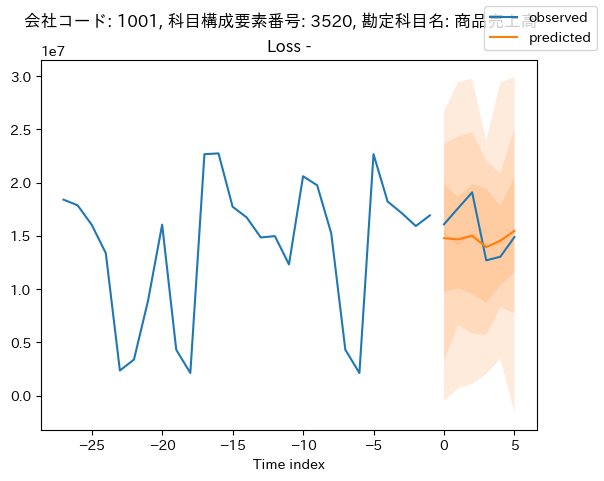

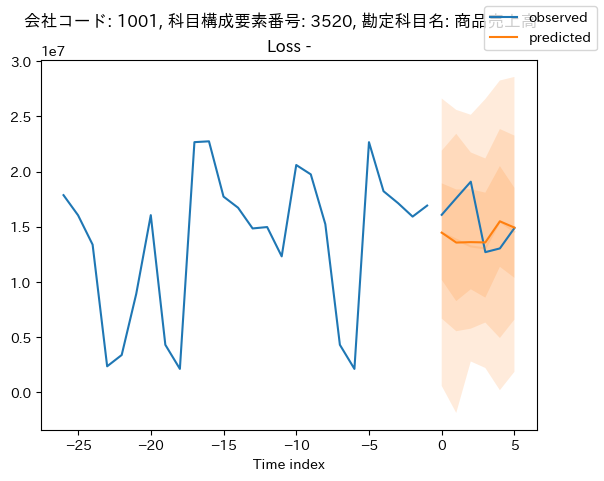

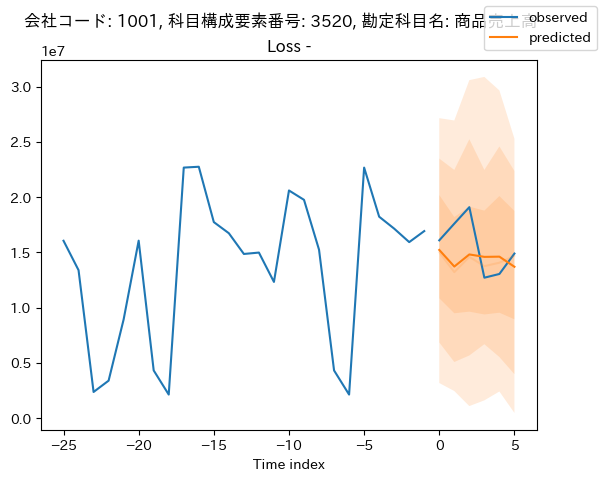

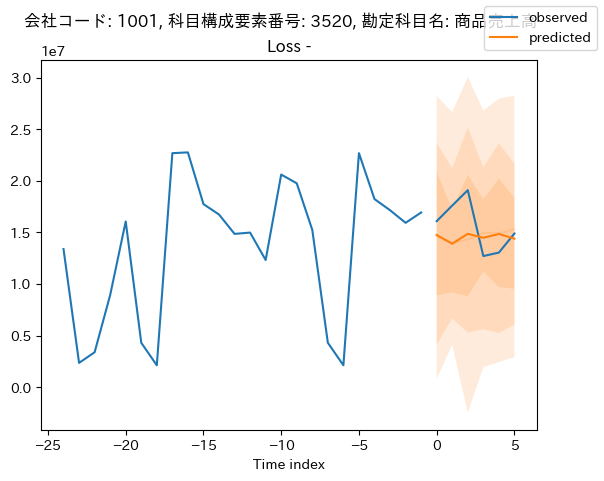

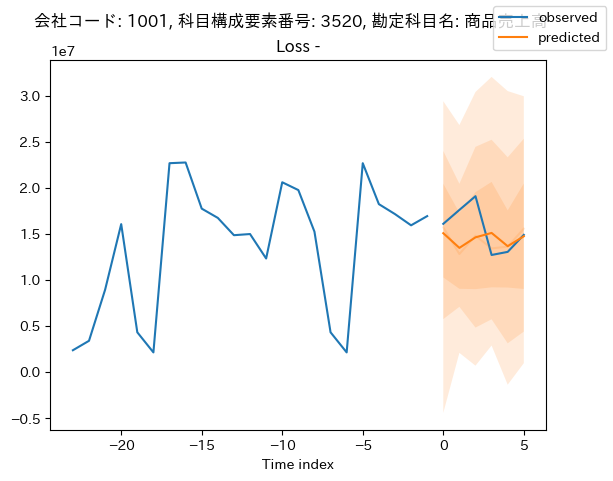

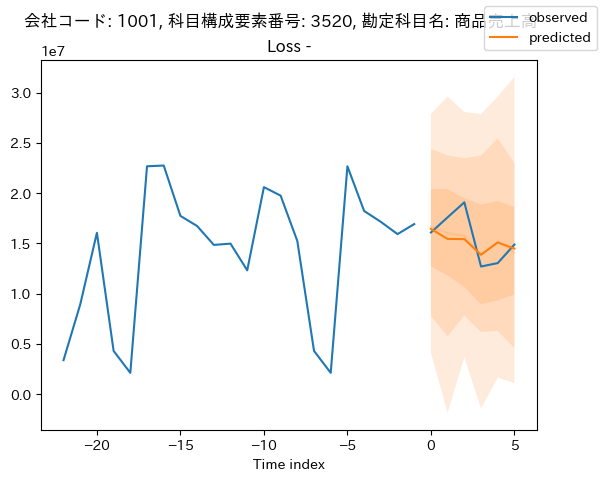

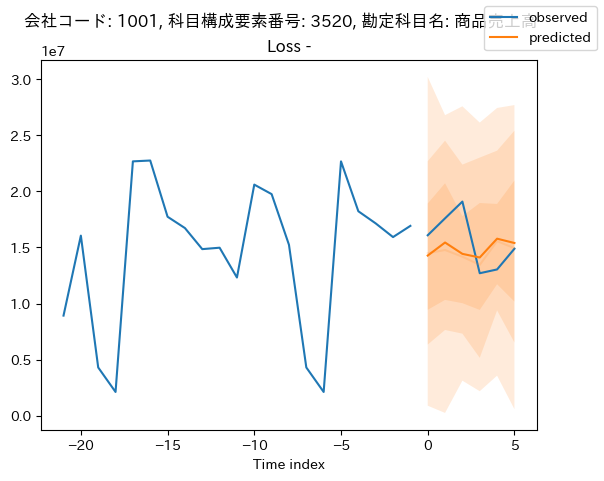

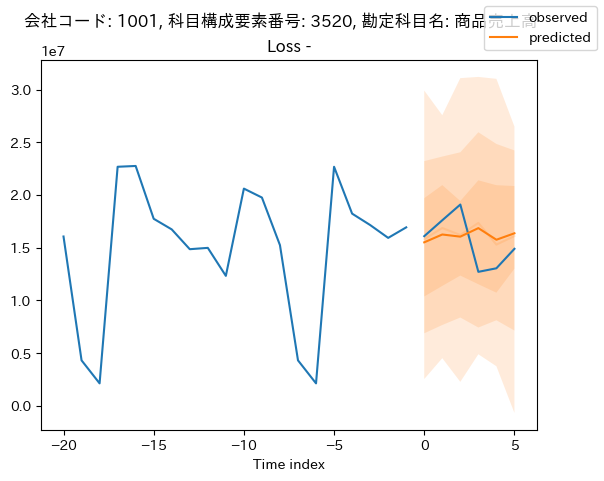

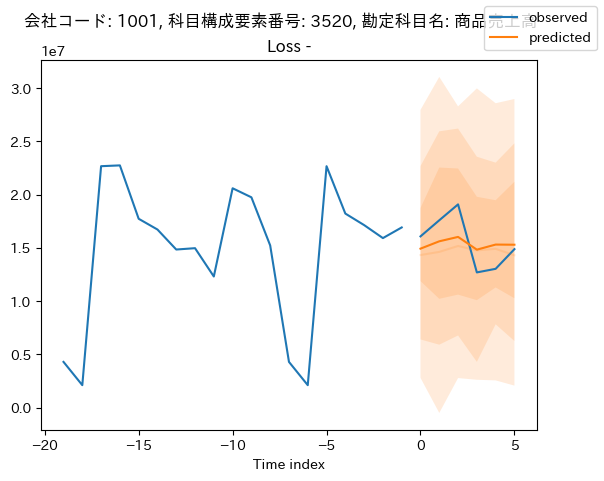

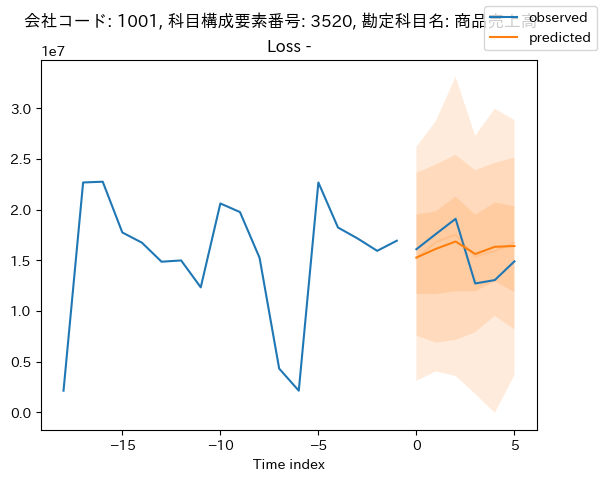

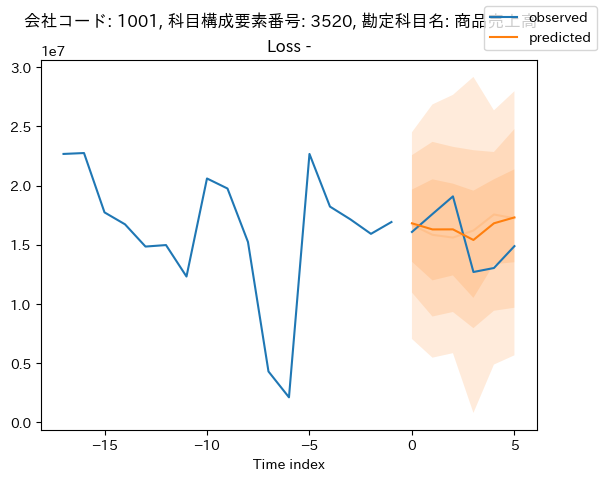

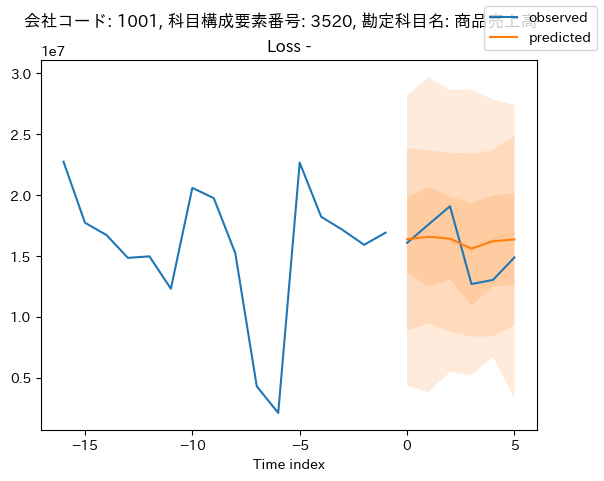

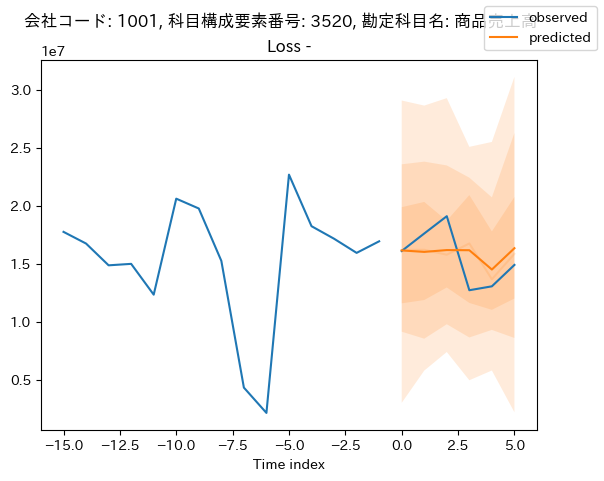

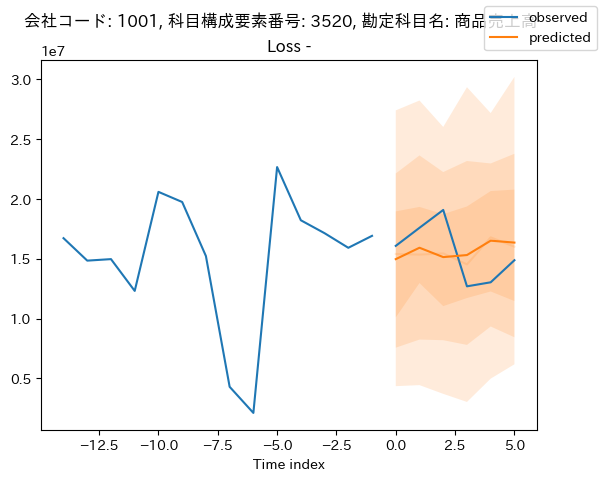

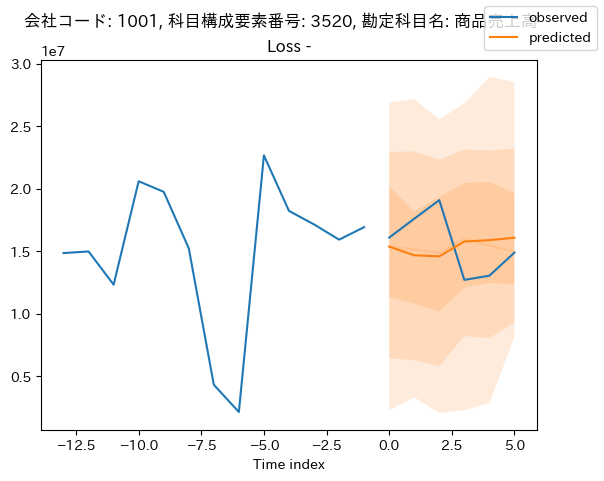

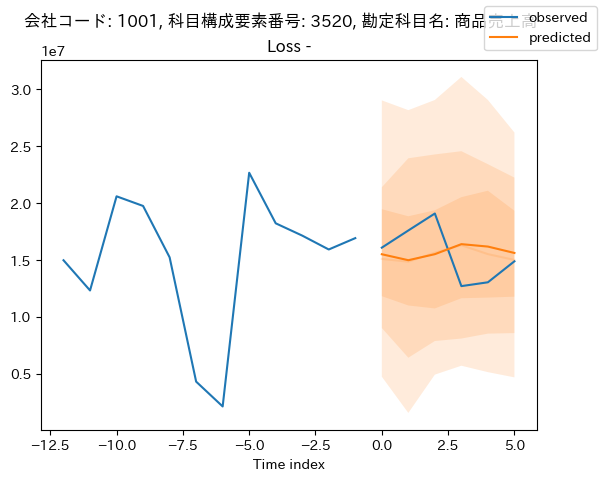

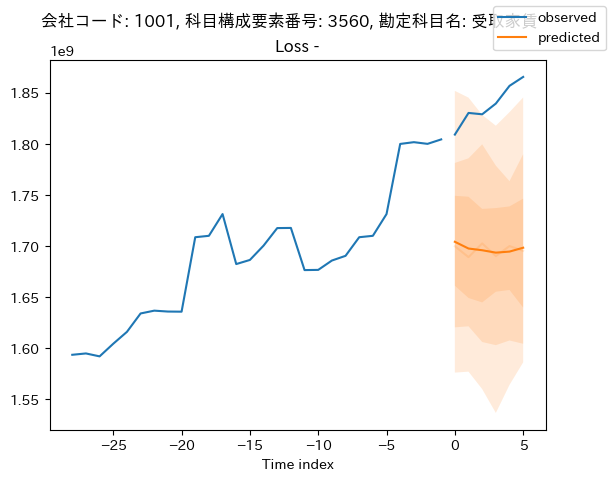

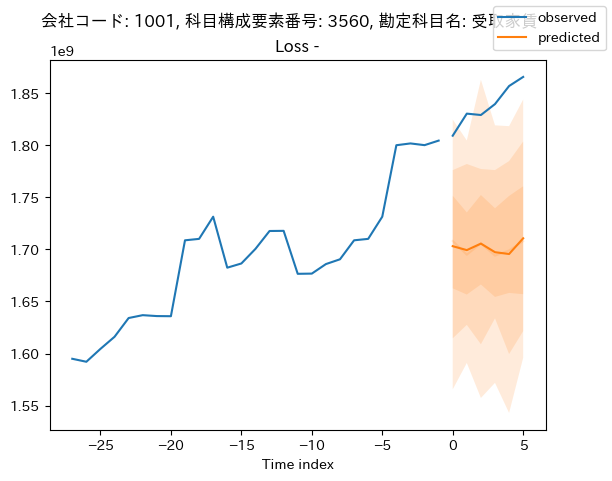

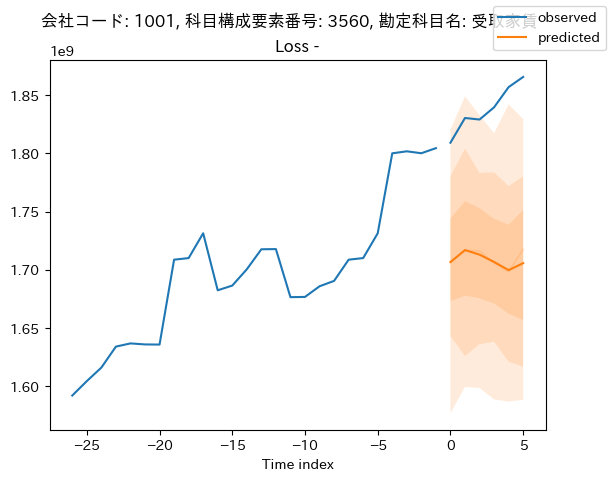

In [ ]:
series_1 = validation.x_to_index(raw_predictions.x)['会社コード']
series_2 = validation.x_to_index(raw_predictions.x)['科目構成要素番号']
series_3 = validation.x_to_index(raw_predictions.x)['勘定科目名']
for idx in range(20):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"会社コード: {series_1.iloc[idx]}, 科目構成要素番号: {series_2.iloc[idx]}, 勘定科目名: {series_3.iloc[idx]}")